In [1]:
import torch

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lola.autoencoder import get_autoencoder
from lola.data import field_preprocess, get_well_inputs, get_well_multi_dataset
from lola.plot import draw_fields, draw_psd

In [2]:
runpath = Path("/mnt/ceph/users/frozet/lola/runs/ae/n6g8kix8_euler_all_dcae_f32c64_large/")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cpu"

## Data

In [3]:
dataset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="valid",
    steps=1,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

In [4]:
x, _ = get_well_inputs(dataset[65432], device=device)
x = preprocess(x)
x = rearrange(x, "1 H W C -> C H W")

## Autoencoder

In [5]:
autoencoder = get_autoencoder(
    pix_channels=dataset.metadata.n_fields,
    **cfg.ae,
)

autoencoder.load_state_dict(
    torch.load(runpath / "state.pth", weights_only=True, map_location=device)
)
autoencoder.to(device)
autoencoder.eval()

AutoEncoder(
  (encoder): DCEncoder(
    (patch): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=1, w=1)
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): SiLU()
            (2): Dropout(p=0.05, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Rearrange('... C (H h) (W w) -> ... (C h w) H W', h=2, w=2)
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-3)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv2d(128, 128

In [6]:
sum(p.numel() for p in autoencoder.parameters())

237625733

## Evaluation

In [7]:
with torch.no_grad():
    z = autoencoder.encode(x.unsqueeze(0))
    y = autoencoder.decode(z).squeeze(0)

error = (x - y).abs().reshape(dataset.metadata.n_fields, -1)

In [8]:
(
    error.mean(axis=-1),
    error.square().mean(axis=-1).sqrt(),
    error.median(axis=-1).values,
    error.max(axis=-1).values,
)

(tensor([0.0079, 0.0200, 0.0088, 0.0124, 0.0128]),
 tensor([0.0119, 0.0387, 0.0134, 0.0213, 0.0222]),
 tensor([0.0054, 0.0100, 0.0059, 0.0077, 0.0079]),
 tensor([0.2183, 0.9928, 0.2401, 0.6073, 0.5575]))

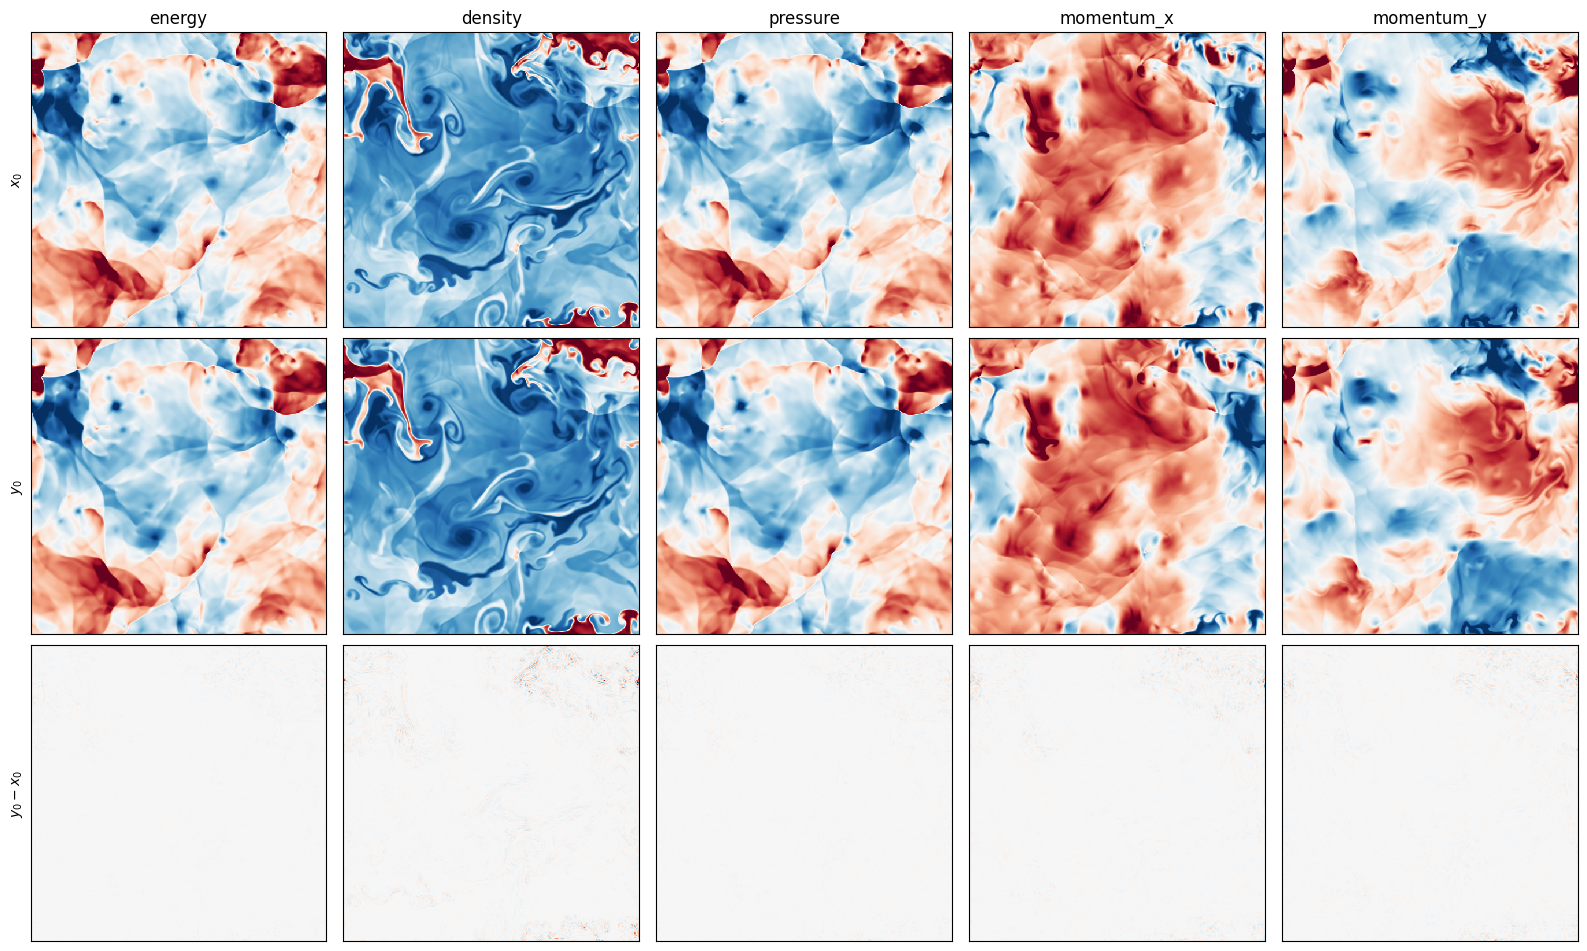

In [12]:
fig = draw_fields(
    x[:, None], y[:, None], fields=cfg.dataset.fields, tolerance=1.0, figsize=(3.2, 3.2)
)

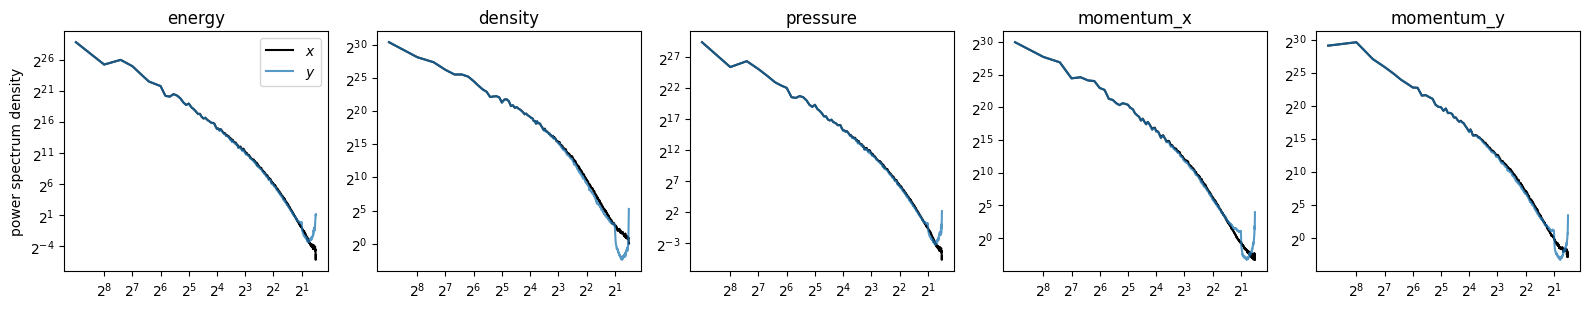

In [10]:
fig = draw_psd(x, y, fields=cfg.dataset.fields)